# Wannierisation (including SAWF)

This tutorial shows how to construct (Symmetry adapted) Wannier functions with WannierBerri, with magnetic symmetries. We will use the example of bcc Fe.
 
## 1. Setup

First import modules and set up the parallel environment

In [1]:

import os

from matplotlib import pyplot as plt
import ray
import scipy
import wannierberri as wberri
import numpy as np
from termcolor import cprint

import warnings
import wannierberri as wb 
tested_version = '1.0.5'
if wb.__version__ != tested_version:
    warnings.warn(f'This tutorial was tested with version {tested_version} of wannierberri')

from wannierberri.parallel import Parallel

from pathlib import Path
path_data = Path("./wannier-berri/tests/data/Fe-444-sitesym/")  # adjust path if needed to point to the data in the tests fo wannier-berri repository
assert os.path.exists(path_data), f"Path {path_data} does not exist"

results_path = {}
results_grid = {}

# We do all calculations for three cases: 
#   1. With all magnetic symmetries (include_TR=True)
#   2. With only the spacegroup symmetries that preserve the magnetic order (include_TR=False)
#   3. Without any symmetries (include_TR=None)

include_TR_list = [True, False, None]  # None means no symmetry

try:
    ray.shutdown()
except:
    pass
parallel = Parallel(ray_init={"num_gpus": 0}) # use of gpus is not tested



2024-12-09 19:09:33,626	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


initializing ray with  {'num_gpus': 0, 'num_cpus': None}


2024-12-09 19:09:35,770	INFO worker.py:1807 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


## 2. Wannierise

In [4]:

w90_data_list = {}

for includeTR in include_TR_list:
    cprint (f"include_TR = {includeTR}", "green", attrs=["bold"])
    w90data=wberri.w90files.Wannier90data(seedname=str(path_data/"Fe")) 
    # check the symmetries of the amn and eig files
    cprint (f"creating dmn", "blue", attrs=["bold"])
    if includeTR is not None:
        sitesym = True
        symmetrizer = wberri.symmetry.symmetrizer_sawf.SymmetrizerSAWF().from_npz(str(path_data/f"Fe_TR={includeTR}.sawf.npz"))
        w90data.set_symmetrizer(symmetrizer)
        print (f"eig is symmetric within the accuracy of : {symmetrizer.check_eig(w90data.eig)}")
        print (f"amn is symmetric within the accuracy of : {symmetrizer.check_amn(w90data.amn, warning_precision=1e-4)}")   
    else:
        sitesym = False

    cprint (f"wannierising", "blue", attrs=["bold"])
    #aidata.apply_outer_window(win_min=-8,win_max= 100 )
    froz_max=30
    w90data.wannierise( init = "amn",
                    froz_min=-8,
                    froz_max=froz_max,
                    print_progress_every=10,
                    num_iter=21,
                    conv_tol=1e-6,
                    mix_ratio_z=1.0,
                    localise=True,
                    sitesym=sitesym,
                    )
    
    w90_data_list[includeTR] = w90data




include_TR = True
kwargs for win are {}
kwargs for eig are {'read_npz': True, 'write_npz': True, 'selected_bands': None}
calling w90 file with wannier-berri/tests/data/Fe-444-sitesym/Fe, eig, tags=['data'], read_npz=True, write_npz=True, kwargs={}
kwargs for mmn are {'read_npz': True, 'write_npz': True, 'selected_bands': None}
calling w90 file with wannier-berri/tests/data/Fe-444-sitesym/Fe, mmn, tags=['data', 'neighbours', 'G'], read_npz=True, write_npz=True, kwargs={'npar': 32}
kwargs for amn are {'read_npz': True, 'write_npz': True, 'selected_bands': None}
calling w90 file with wannier-berri/tests/data/Fe-444-sitesym/Fe, amn, tags=['data'], read_npz=True, write_npz=True, kwargs={'npar': 32}
apply_window amn, selected_bands=None
creating CheckPoint_bare
kwargs for chk are {'selected_bands': None}
creating dmn
time for read_npz dmn 0.02032637596130371
 init 0.0005371570587158203 
 d_blocks 0.01978921890258789
time for read_npz dmn 0.04262828826904297
 super 0.020351886749267578 
 spac

## 3. Create System_w90 objects

In [12]:

systems = {}
for includeTR in include_TR_list:
    cprint (f"include_TR = {includeTR}", "green", attrs=["bold"])
    systems[includeTR]=wberri.system.System_w90(w90data= w90_data_list[includeTR], berry=True, transl_inv_JM=True, transl_inv_MV=False, wcc_phase_fin_diff=False)
    if includeTR is not None:
        systems[includeTR].symmetrize2(w90_data_list[includeTR].symmetrizer)


include_TR = True


/home/stepan/github/wannirrep/wannier-berri/wannierberri/system/system_w90.py:145: UserWarning: converting convention II to convention I is not recommended.Better use 'wcc_phase_fin_dif=True' or `transl_inv_JM=True`
  warnings.warn("converting convention II to convention I is not recommended."


expjphase1 (18, 18, 12)
irvec_new_all shape (89,)
using ws_dist for Ham
using ws_dist for AA
Real-space lattice:
 [[ 1.4349963  1.4349963  1.4349963]
 [-1.4349963  1.4349963  1.4349963]
 [-1.4349963 -1.4349963  1.4349963]]
Number of wannier functions: 18
Number of R points: 89
Recommended size of FFT grid [4 4 4]
Wannier Centers cart (raw):
 [[-5.63158389e-12 -3.09021554e-12 -5.46987408e-12]
 [ 2.51804729e-13  3.33666446e-12 -9.01234293e-12]
 [-1.85763607e-10  9.25788048e-10 -7.52352973e-11]
 [-1.76113662e-10 -1.65917387e-11 -1.49156836e-11]
 [ 1.86803098e-10 -8.80468021e-10 -6.20267102e-10]
 [ 6.65055864e-11  7.19792239e-11 -4.50787177e-10]
 [ 1.75425938e-10  1.92524276e-11  5.55439883e-10]
 [ 4.55444759e-10  2.21277204e-11  6.22900766e-10]
 [-1.43134076e-12  1.23651555e-11  1.32374347e-12]
 [-2.83984881e-12 -3.92285626e-13  5.36279740e-13]
 [-7.11567004e-12  6.98046886e-12  1.54087139e-13]
 [ 6.26022625e-13 -5.63250371e-13 -1.31075618e-13]
 [-4.48168140e-12  1.82997502e-12  8.4650598

## 4. Bands along path

### 4.1 calculate bands

In [13]:
results_path = {}

for includeTR in include_TR_list:
    cprint (f"include_TR = {includeTR}", "green", attrs=["bold"])
    system = systems[includeTR] 
    # system.set_symmetry(spacegroup=bandstructure.spacegroup)
    tabulators = { "Energy": wberri.calculators.tabulate.Energy(),
                }


    tab_all_path = wberri.calculators.TabulatorAll(
                        tabulators,
                        ibands=np.arange(0,18),
                        mode="path"
                            )

    # all kpoints given in reduced coordinates
    path=wberri.Path(system,
                    k_nodes=[
                        [0.0000, 0.0000, 0.0000 ],   #  G
                        [0.500 ,-0.5000, -0.5000],   #  H
                        [0.7500, 0.2500, -0.2500],   #  P
                        [0.5000, 0.0000, -0.5000],   #  N
                        [0.0000, 0.0000, 0.000  ]
                            ] , #  G
                    labels=["G","H","P","N","G"],
                    length=200 )   # length [ Ang] ~= 2*pi/dk

    results_path[includeTR]=wberri.run(system,
                    parallel=parallel,
                    grid=path,
                    calculators={"tabulate" : tab_all_path},
                    print_Kpoints=False)



include_TR = True
Starting run()
Using the follwing calculators : 
############################################################

 'tabulate'  :  <wannierberri.calculators.tabulate.TabulatorAll object at 0x7fd1fc108560>  : 
    TabulatorAll - a pack of all k-resolved calculators (Tabulators)
    
 Includes the following tabulators : 
--------------------------------------------------
 "Energy" : <wannierberri.calculators.tabulate.Energy object at 0x7fd1e302c920> : calculator not described

--------------------------------------------------

############################################################
Calculation along a path - checking calculators for compatibility
tabulate <wannierberri.calculators.tabulate.TabulatorAll object at 0x7fd1fc108560>
All calculators are compatible
Symmetrization switched off for Path
Grid is regular
The set of k points is a Path() with 215 points and labels {0: 'G', 70: 'H', 130: 'P', 165: 'N', 214: 'G'}
generating K_list
Done 
Done, sum of weights:215.0
pr

/home/stepan/github/wannirrep/wannier-berri/wannierberri/grid/path.py:163: UserWarning: symmetry is not used for a tabulation along path
  warnings.warn("symmetry is not used for a tabulation along path")


time for processing    215 K-points on  32 processes:     0.0753 ; per K-point          0.0004 ; proc-sec per K-point          0.0112
time1 =  0.0031366348266601562
Totally processed 215 K-points 
run() finished


### 4.2 plot bands

include_TR = True
include_TR = False
include_TR = None


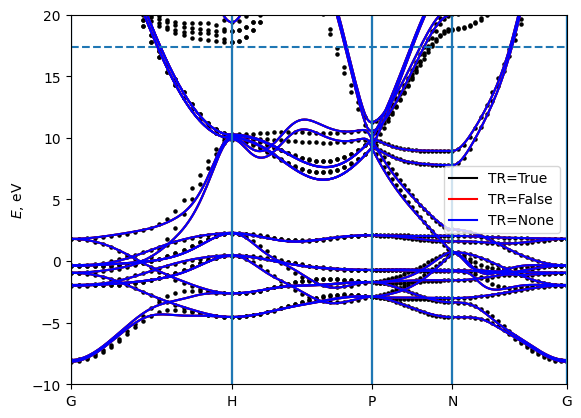

In [14]:

# plot the bands and compare with pw
EF = 12.6

A = np.loadtxt(path_data / "Fe_bands_pw.dat")
bohr_ang = scipy.constants.physical_constants['Bohr radius'][0] / 1e-10
alatt = 5.4235* bohr_ang
A[:,0]*= 2*np.pi/alatt
A[:,1] = A[:,1] - EF
plt.scatter(A[:,0], A[:,1], c="black", s=5)

colors = ["blue", "red","black"]
for includeTR in include_TR_list:
    cprint (f"include_TR = {includeTR}", "green", attrs=["bold"])
    
    path_result = results_path[includeTR].results["tabulate"]

    path_result.plot_path_fat(path,
                quantity=None,
                # save_file="Fe_bands.pdf",
                Eshift=EF,
                Emin=-10, Emax=50,
                iband=None,
                mode="fatband",
                fatfactor=20,
                cut_k=False,
                linecolor=colors.pop(),
                close_fig=False,
                show_fig=False,
                label=f"TR={includeTR}"
                )

plt.ylim(-10, 20)
plt.hlines(froz_max-EF, 0, A[-1,0], linestyles="dashed")
plt.legend()
plt.savefig("Fe_bands.pdf")


## 5. AHC and Ohmic conductivity

### 5.1 calculate 

In [15]:
results_grid = {}
efermi = np.linspace(12.4,12.8,1001)
param = dict(Efermi=efermi)
calculators_grid = {
     "CDOS": wberri.calculators.static.CumDOS(**param),
                "ohmic": wberri.calculators.static.Ohmic_FermiSea(**param),
                "ahc_internal": wberri.calculators.static.AHC(kwargs_formula={"external_terms":False}, **param),
            "ahc_external": wberri.calculators.static.AHC(kwargs_formula={"internal_terms":False}, **param ),	
}

for includeTR in include_TR_list:
    cprint (f"include_TR = {includeTR}", "green", attrs=["bold"])
    system = systems[includeTR]
    grid =  wberri.Grid(system, NKFFT=6, NK=48)

    results_grid[includeTR] = wberri.run(system, grid, calculators_grid, 
                                          fout_name="Fe_grid",
                                          suffix = f"TR={includeTR}",
                                          adpt_num_iter=0,
                                          symmetrize=False,  # we do not symmetrize here so that we can chaeck how symmetric are the WFs
                                          use_irred_kpt=False,
                                          print_progress_step=1,
                                          parallel=parallel,
                                          print_Kpoints=False,
                                          )




# plot the bands to compare with pw





include_TR = True
Starting run()
Using the follwing calculators : 
############################################################

 'CDOS'  :  <wannierberri.calculators.static.CumDOS object at 0x7fd1f07534a0>  : Cumulative density of states
 'ohmic'  :  <wannierberri.calculators.static.Ohmic_FermiSea object at 0x7fd1c018a0c0>  : Ohmic conductivity (:math:`S/m`)

        | With Fermi sea integral. Eq(31) in `Ref <https://www.nature.com/articles/s41524-021-00498-5>`__
        | Output: :math:`\sigma_{\alpha\beta} = e^2/\hbar \tau \int [dk] \partial_\beta v_\alpha f`for \tau=1fs| Instruction: :math:`j_\alpha = \sigma_{\alpha\beta} E_\beta`
 'ahc_internal'  :  <wannierberri.calculators.static.AHC object at 0x7fd1f069aa20>  : Anomalous Hall conductivity (:math:`s^3 \cdot A^2 / (kg \cdot m^3) = S/m`)

        | With Fermi sea integral Eq(11) in `Ref <https://www.nature.com/articles/s41524-021-00498-5>`__
        | Output: :math:`O = -e^2/\hbar \int [dk] \Omega f`
        | Instruction: :math:`

### 5.2 Plot 

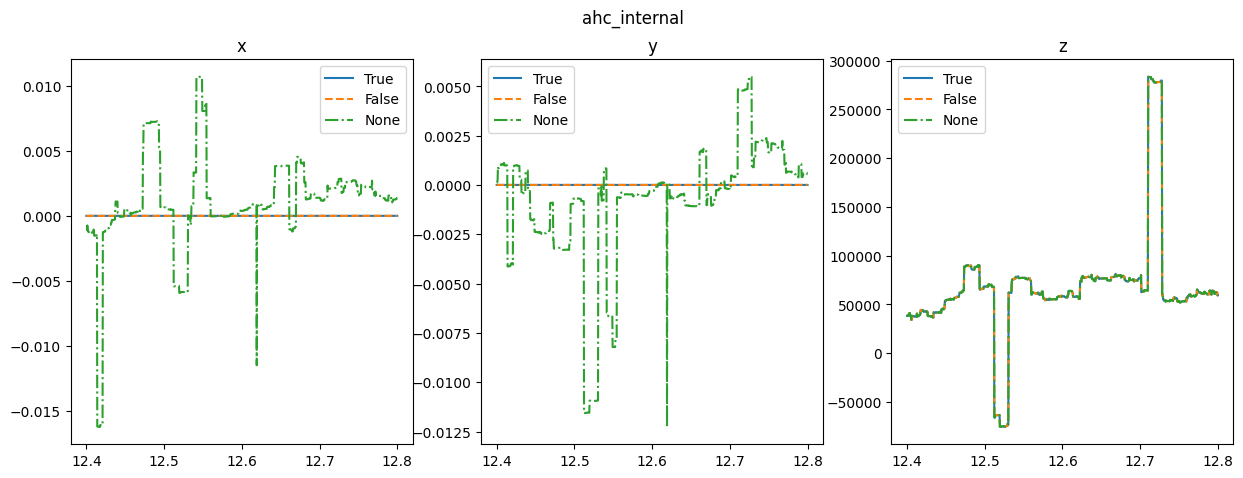

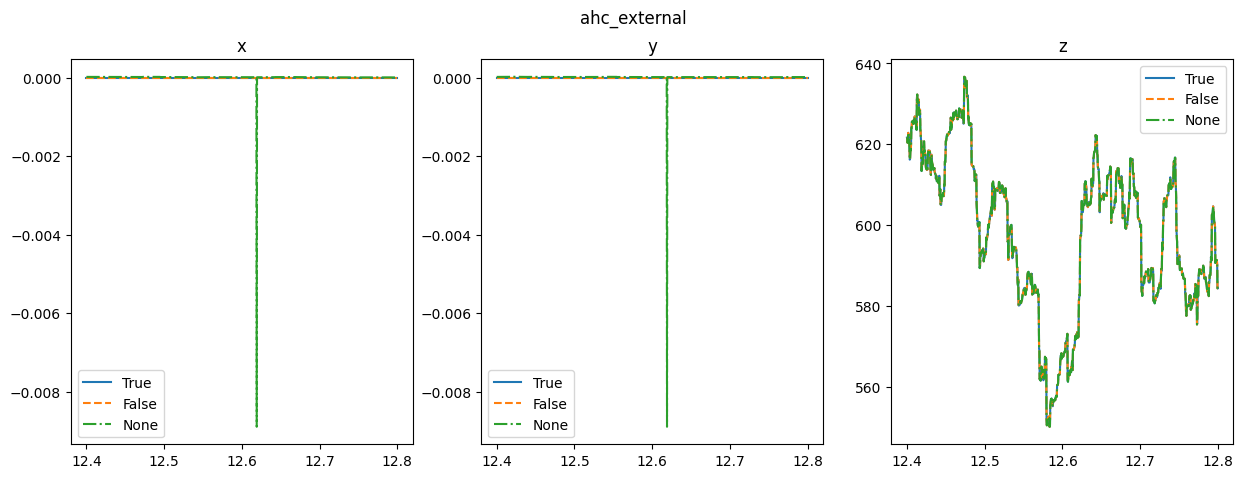

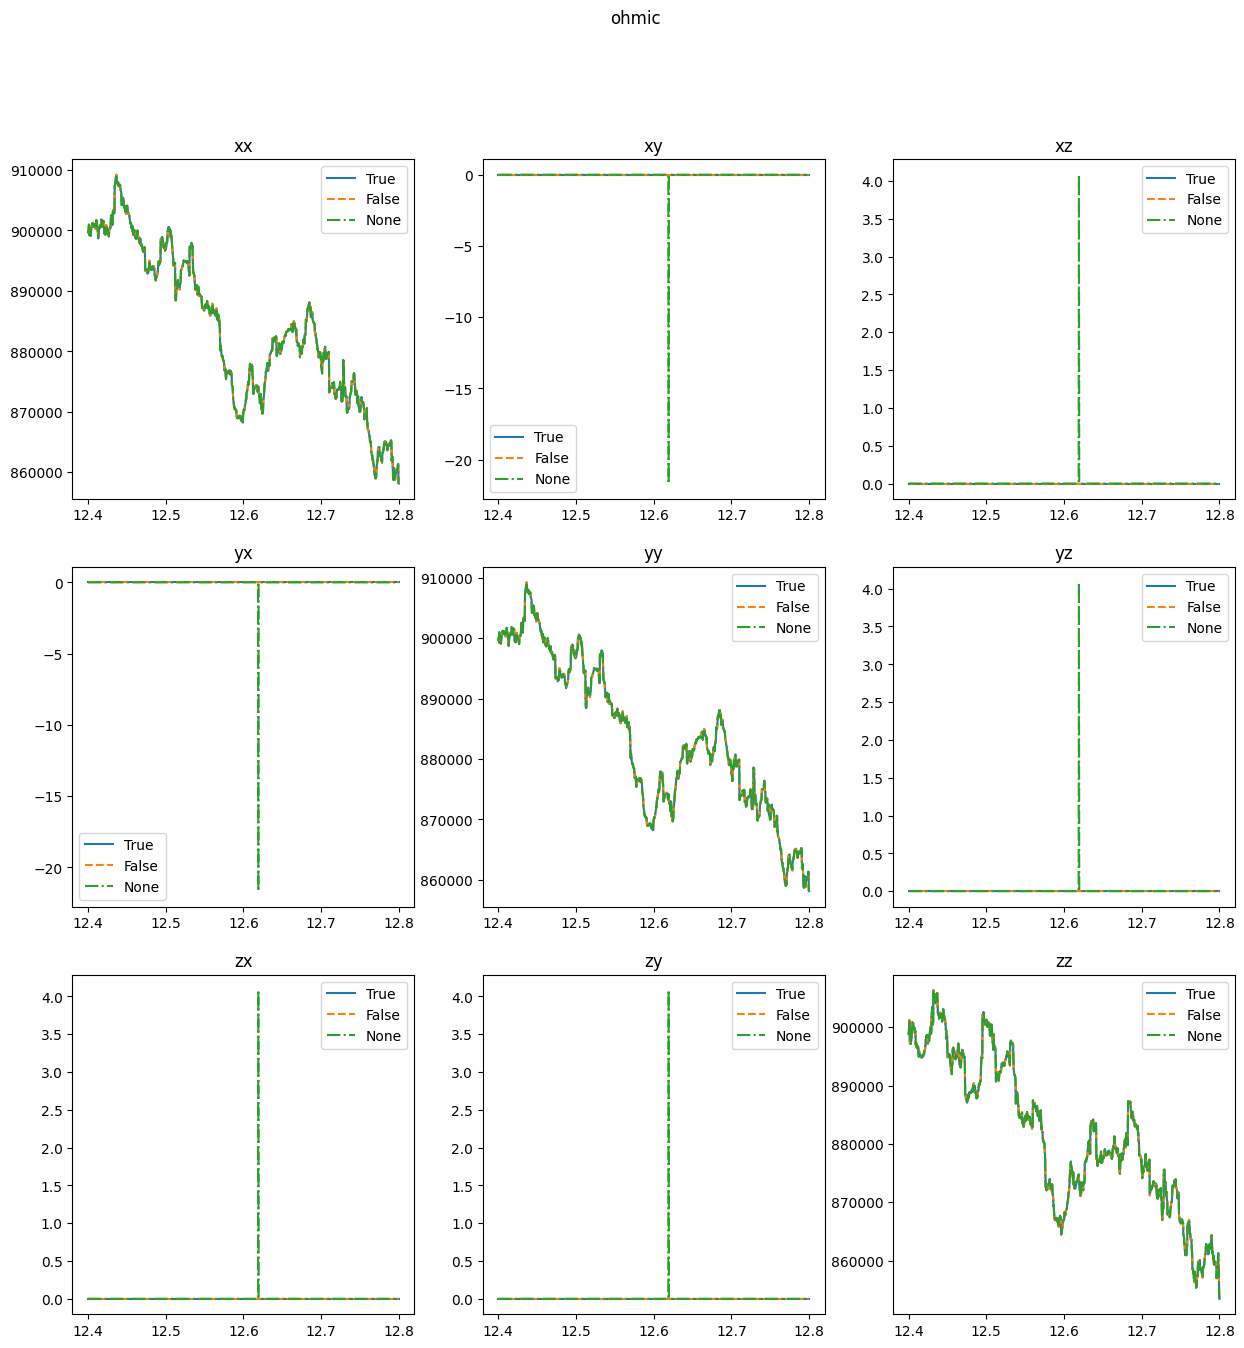

In [17]:
def plotxyz(axes, x, data, pre = "", label="",ls="-"):
    for i in range(3):
        ax =axes[i]
        ax.plot(x, data[:,i], ls, label=label)
        ax.set_title(f"{pre}{'xyz'[i]}")



quantities =  ["ahc_internal", "ahc_external","ohmic"]
linestyles = {k:v for k,v in zip( include_TR_list, ["-", "--", "-."])}
    
nfig = len(quantities)
for quantity in quantities:
    fig = None
    for includeTR in include_TR_list:
        res = results_grid[includeTR].results[quantity]
        data = res.data
        E = res.Energies[0]
        if fig is None:
            if data.ndim == 2:
                nfigx = 1
                nfigy = data.shape[1]
            elif data.ndim == 3:
                nfigx = data.shape[1]
                nfigy = data.shape[2]
            fig, axes = plt.subplots(nfigx, nfigy, figsize=(5*nfigy,5*nfigx))
        if nfigx ==1:
            plotxyz(axes, E, data, label=f"{includeTR}", ls=linestyles[includeTR])
        else:
            for i in range(nfigx):
                plotxyz(axes[i], E, data[:,i], pre="xyz"[i], label=f"{includeTR}", ls=linestyles[includeTR])
    for ax in axes.flat:
        ax.legend()
    fig.suptitle(quantity)
    plt.show()
    plt.close()
    
        


## 6. Creating the SymmetrizerSAWF files

The `wannierberri.symemtry.stmmetrizer_sawf.SymmetrizerSAWF` class is used to store the information on how the dft bands, and the Wannier functions 
transform under spac-group (ot magnetic group) symmetries. This information is used to construct the SAWF, to search for projections, and to symmetrize the system (using the System_R.symmetrize2 methos)

Initially it was a class to manipulate the dmn file of Wannier90, but it developed into a more sophisticated class. Still in can be used to generate the dmn filem but the class cannot be initatialized with a dmn file.

Compared, to the wannier90.dmn file, the SytmmetrizerSAWF has the following advantages:

* The matrices D_wann and d_band are stored in block diagonal form, which saves memory and allows for faster calculations.
    - for d_band the blocks correspond to (almost) degenerate bands
    - for D_wann the blocks correspond to the same orbital at the same Wyckoff position
* The information on magnetic symmeties (which symmetry operation includes time reversal)
* The spacegroup is stored as an irrep.spacegroup.Spacegroup object, which allows for easy manipulation of the symmetry operations

### 6.1 read the bandstructure using irrep

In [23]:

from irrep.bandstructure import BandStructure
path_data = Path("./wannier-berri/tests/data/Fe-222-pw/")
assert os.path.exists(path_data), f"Path {path_data} does not exist"
  # adjust path if needed to point to the data in the tests fo wannier-berri repository
bandstructure = BandStructure(code='espresso',   # to work with VASP or abinit please refer to the documentation of irrep
                            prefix=str(path_data / "Fe"),
                            Ecut=100,
                            normalize=False,
                            magmom=[[0,0,1]],  # set the magnetic moments for a magnetic system (units do not matter)
                            include_TR=False)  # set include_TR=False if you do not want to include the symmetries involving time reversal
bandstructure.spacegroup.show()
symmetrizer = wberri.symmetry.symmetrizer_sawf.SymmetrizerSAWF().from_irrep(bandstructure)





 ---------- CRYSTAL STRUCTURE ---------- 


Cell vectors in angstroms:

      Vectors of DFT cell       |      Vectors of REF. cell      
a0 =  1.4350   1.4350   1.4350  |  a0 =  1.4350  -1.4350  -1.4350
a1 = -1.4350   1.4350   1.4350  |  a1 =  1.4350   1.4350  -1.4350
a2 = -1.4350  -1.4350   1.4350  |  a2 =  1.4350   1.4350   1.4350

Atomic positions in direct coordinates:

Atom type |   Position in DFT cell    |   Position in REF cell   
    1     |  0.0000   0.0000   0.0000 |  0.0000   0.0000   0.0000


 ---------- SPACE GROUP ----------- 


Space group: magnetic-unknown (# None)
Number of symmetries: 8 (mod. lattice translations)

The transformation from the DFT cell to the reference cell of tables is given by: 
        |   1.0000  0.0000  0.0000 |
refUC = |   0.0000  1.0000  0.0000 |    shiftUC = [0. 0. 0.]
        |   0.0000  0.0000  1.0000 |


 ### 1 

rotation : |  1   0   0 |
           |  0   1   0 |
           |  0   0   1 |


 gk = [kx, ky, kz]

spinor rot.         : | 1.

### Set projections

In [ ]:

# now set the transformations of WFs. Make sure, the projections are consistent with the amn file
pos = [[0,0,0]]
symmetrizer.set_D_wann_from_projections(projections=[(pos, 's'), (pos,'p'), (pos,'d')])

#write on disk
symmetrizer.to_npz("Fe_spd.sawf.npz")

# later can be read with
symmetrizer_read_npz = wberri.symmetry.symmetrizer_sawf.SymmetrizerSAWF().from_npz("Fe_spd.sawf.npz")

# or write to w90 file (wiss not work if include_TR is True)
symmetrizer.to_w90_file("Fe_spd") # Works only if tinclude_TR is False



calculating Wannier functions for s at [[0, 0, 0]]
calculating Wannier functions for p at [[0, 0, 0]]
calculating Wannier functions for d at [[0, 0, 0]]
len(D_wann_list) = 3
D.shape [(4, 8, 2, 2), (4, 8, 6, 6), (4, 8, 10, 10)]
num_wann 18
D_wann_block_indices [[ 0  2]
 [ 2  8]
 [ 8 18]]
saving to Fe_spd.sawf.npz : 
time for read_npz dmn 0.00843048095703125
 init 0.0007269382476806641 
 d_blocks 0.007703542709350586
time for read_npz dmn 0.018683433532714844
 super 0.008509397506713867 
 spacegroup 0.00956416130065918
  T 0.0006098747253417969 
writing Fe_spd.dmn:  comment = Generated by wannierberri with irrep
